# Практическое занятие 10: Инженерия признаков и настройка гиперпараметров

**Курс:** Интеллектуальный анализ данных  
**Преподаватель:** Абилев Нурмухамед  

## Цели практического занятия

- Применить методы инженерии признаков на реальных данных
- Сравнить различные подходы к предобработке данных
- Настроить гиперпараметры различными методами
- Оценить влияние инженерии признаков на производительность модели

---

## Установка и импорт библиотек

In [11]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


## Задание 1: Загрузка и исследование данных

Мы будем работать с набором данных Titanic для демонстрации инженерии признаков.

In [12]:
# Загрузка данных Titanic
# Если файл недоступен, создадим синтетические данные
try:
    # Попытка загрузить реальные данные
    from seaborn import load_dataset
    data = load_dataset('titanic')
    print("Данные Titanic загружены успешно!")
except:
    # Создание синтетических данных, похожих на Titanic
    np.random.seed(42)
    n_samples = 891
    
    data = pd.DataFrame({
        'survived': np.random.choice([0, 1], n_samples, p=[0.62, 0.38]),
        'pclass': np.random.choice([1, 2, 3], n_samples, p=[0.24, 0.21, 0.55]),
        'sex': np.random.choice(['male', 'female'], n_samples, p=[0.65, 0.35]),
        'age': np.random.normal(29.7, 14.5, n_samples),
        'sibsp': np.random.poisson(0.52, n_samples),
        'parch': np.random.poisson(0.38, n_samples),
        'fare': np.random.exponential(32, n_samples),
        'embarked': np.random.choice(['S', 'C', 'Q'], n_samples, p=[0.72, 0.19, 0.09]),
        'class': np.random.choice(['First', 'Second', 'Third'], n_samples, p=[0.24, 0.21, 0.55]),
        'deck': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F', 'G', None], n_samples, p=[0.05, 0.05, 0.06, 0.04, 0.04, 0.02, 0.01, 0.73])
    })
    
    # Добавим пропуски как в реальных данных
    data.loc[np.random.choice(data.index, 177, replace=False), 'age'] = np.nan
    data.loc[np.random.choice(data.index, 2, replace=False), 'embarked'] = np.nan
    
    print("Синтетические данные созданы!")

# Исследование данных
print(f"Размер датасета: {data.shape}")
print("\nИнформация о данных:")
print(data.info())
print("\nПервые 5 строк:")
data.head()

Данные Titanic загружены успешно!
Размер датасета: (891, 15)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### TODO 1.1: Исследовательский анализ данных

Выполните следующие задачи:
1. Изучите статистики по каждому признаку
2. Проверьте наличие пропусков в данных
3. Постройте распределения признаков
4. Проанализируйте корреляции между признаками


Описательная статистика (числовые признаки):
          count       mean        std   min      25%      50%   75%       max
survived  891.0   0.383838   0.486592  0.00   0.0000   0.0000   1.0    1.0000
pclass    891.0   2.308642   0.836071  1.00   2.0000   3.0000   3.0    3.0000
age       714.0  29.699118  14.526497  0.42  20.1250  28.0000  38.0   80.0000
sibsp     891.0   0.523008   1.102743  0.00   0.0000   0.0000   1.0    8.0000
parch     891.0   0.381594   0.806057  0.00   0.0000   0.0000   0.0    6.0000
fare      891.0  32.204208  49.693429  0.00   7.9104  14.4542  31.0  512.3292

Описательная статистика (все признаки):
             count unique          top freq       mean        std   min  \
survived     891.0    NaN          NaN  NaN   0.383838   0.486592   0.0   
pclass       891.0    NaN          NaN  NaN   2.308642   0.836071   1.0   
sex            891      2         male  577        NaN        NaN   NaN   
age          714.0    NaN          NaN  NaN  29.699118  14.526497  

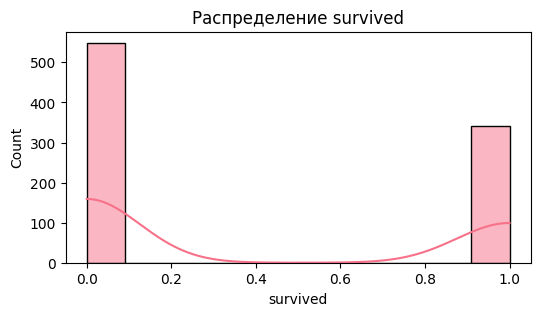

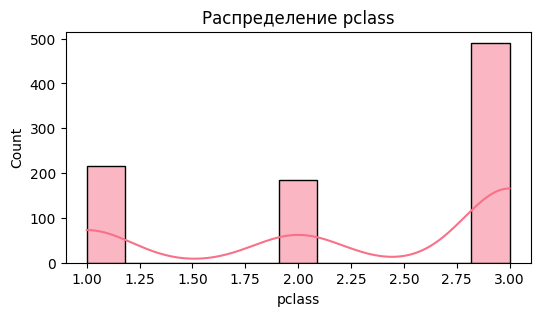

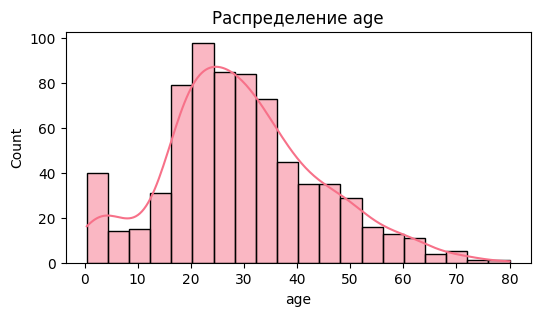

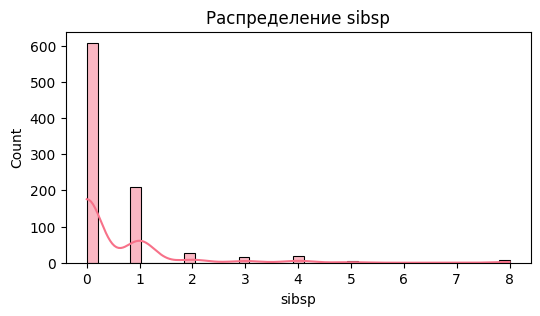

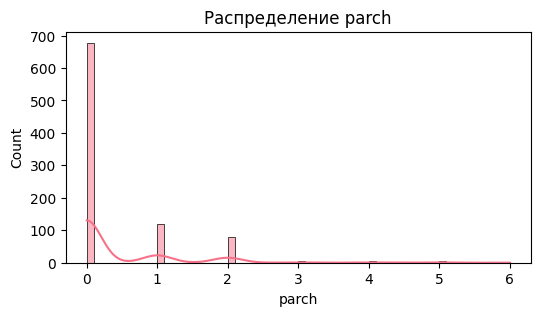

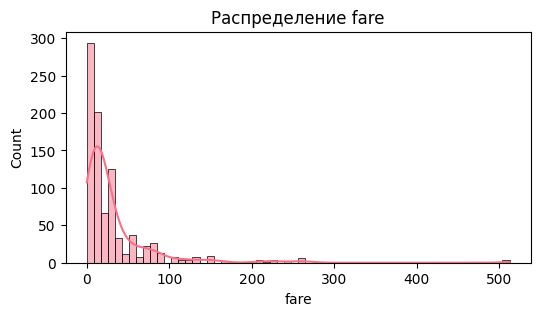

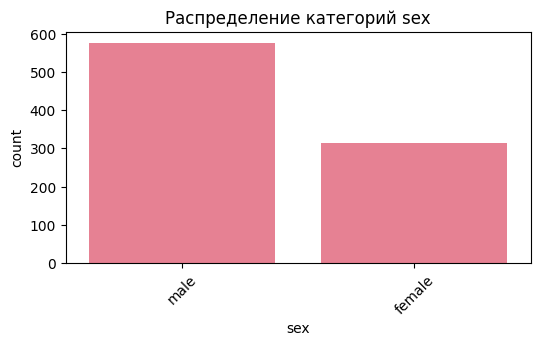

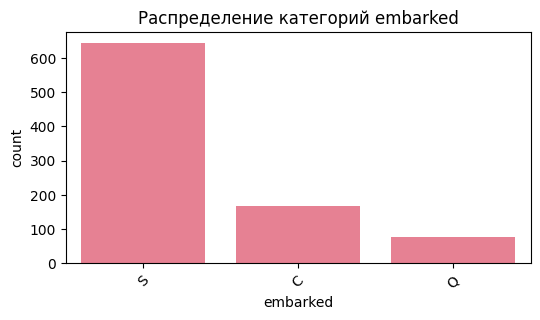

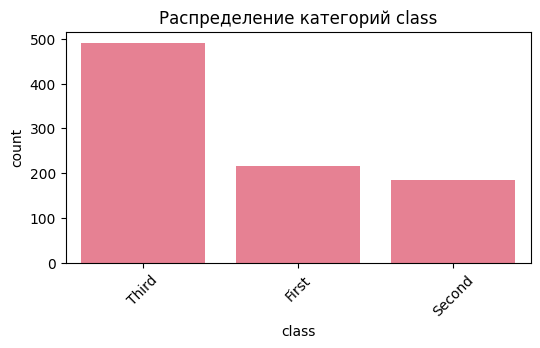

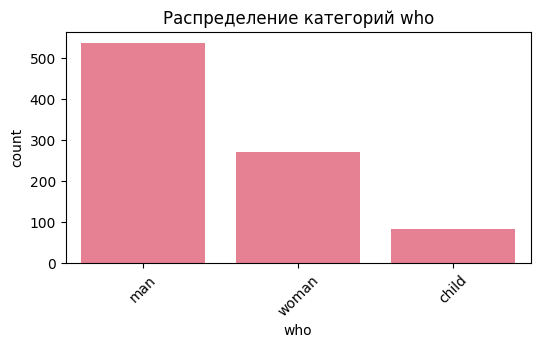

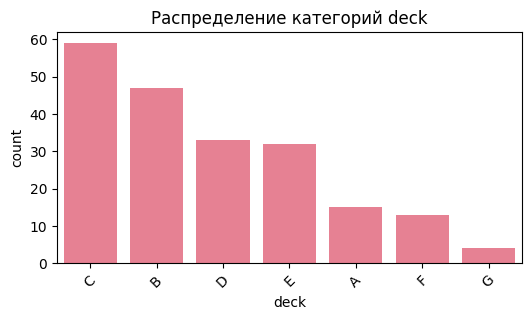

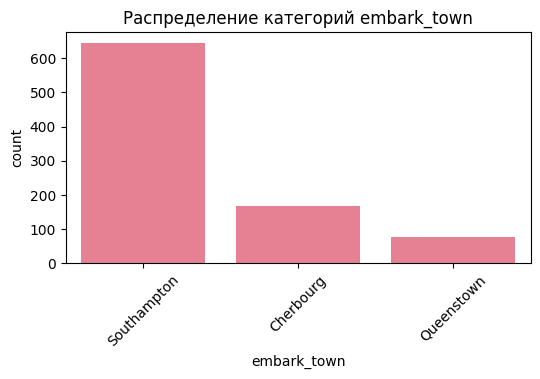

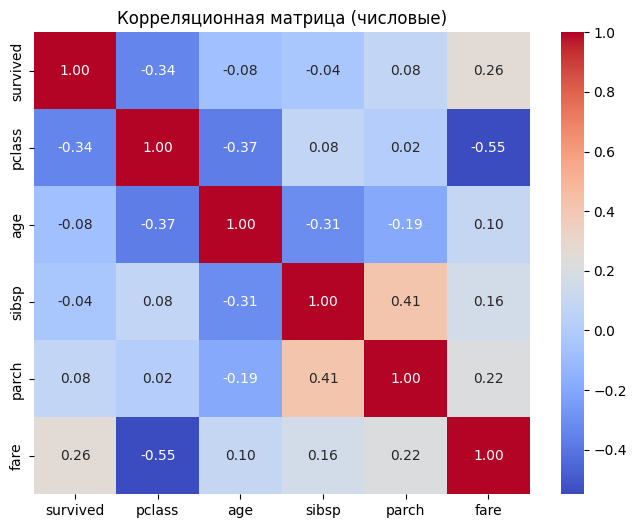

In [13]:
# TODO 1.1: Выполните исследовательский анализ данных

# 1. Описательная статистика
print('\nОписательная статистика (числовые признаки):')
print(data.describe().T)
print('\nОписательная статистика (все признаки):')
print(data.describe(include='all').T)

# 2. Проверка пропусков
print('\nПропуски по столбцам:')
print(data.isnull().sum())

# 3. Распределения признаков (числовые)
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(data[col].dropna(), kde=True)
    plt.title(f'Распределение {col}')
    plt.show()

# Категориальные признаки (первые 6)
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols[:6]:
    plt.figure(figsize=(6,3))
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.title(f'Распределение категорий {col}')
    plt.xticks(rotation=45)
    plt.show()

# 4. Корреляционная матрица (числовые признаки)
if len(numeric_cols) > 1:
    corr = data[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Корреляционная матрица (числовые)')
    plt.show()


## Задание 2: Обработка пропущенных значений

Пропущенные значения - одна из основных проблем при работе с реальными данными.

### TODO 2.1: Стратегии обработки пропусков

Реализуйте различные стратегии обработки пропущенных значений:

In [14]:
# TODO 2.1: Обработка пропущенных значений

# Создаем копию данных для экспериментов
data_processed = data.copy()

# 1. Обработка пропусков в числовых признаках (age)
# Попробуем различные стратегии, сохраним временные варианты
if 'age' in data_processed.columns:
    data_processed['age_mean_fill'] = data_processed['age'].fillna(data_processed['age'].mean())
    data_processed['age_median_fill'] = data_processed['age'].fillna(data_processed['age'].median())
    # Выберем медиану как основную стратегию (устойчива к выбросам)
    data_processed['age'] = data_processed['age'].fillna(data_processed['age'].median())

# 2. Обработка пропусков в категориальных признаках (embarked)
if 'embarked' in data_processed.columns:
    most_freq = data_processed['embarked'].mode()
    if not most_freq.empty:
        data_processed['embarked'] = data_processed['embarked'].fillna(most_freq.iloc[0])

# 3. Создайте индикаторные признаки для пропусков
if 'age' in data.columns:
    data_processed['age_missing'] = data['age'].isnull().astype(int)
if 'embarked' in data.columns:
    data_processed['embarked_missing'] = data['embarked'].isnull().astype(int)

print("Пропуски после обработки:")
print(data_processed.isnull().sum())


Пропуски после обработки:
survived              0
pclass                0
sex                   0
age                   0
sibsp                 0
parch                 0
fare                  0
embarked              0
class                 0
who                   0
adult_male            0
deck                688
embark_town           2
alive                 0
alone                 0
age_mean_fill         0
age_median_fill       0
age_missing           0
embarked_missing      0
dtype: int64


## Задание 3: Кодирование категориальных признаков

Машинное обучение работает с числовыми данными, поэтому нужно преобразовать категориальные признаки.

### TODO 3.1: Применение различных методов кодирования

Примените разные методы кодирования к категориальным признакам:

In [15]:
# TODO 3.1: Кодирование категориальных признаков

# 1. Label Encoding для порядковых признаков (pclass)
if 'pclass' in data_processed.columns:
    try:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        data_processed['pclass_le'] = le.fit_transform(data_processed['pclass'].astype(str))
    except Exception:
        data_processed['pclass_le'] = data_processed['pclass']

# 2. One-Hot Encoding для номинальных признаков (sex, embarked)
onehot_cols = [c for c in ['sex', 'embarked'] if c in data_processed.columns]
if onehot_cols:
    data_processed = pd.get_dummies(data_processed, columns=onehot_cols, drop_first=True)

# 3. Target Encoding для признака с большим количеством категорий (например, deck)
if 'deck' in data_processed.columns and 'survived' in data_processed.columns:
    deck_target = data_processed.groupby('deck')['survived'].mean()
    data_processed['deck_target_enc'] = data_processed['deck'].map(deck_target)
    # Заполним отсутствующие значения средним по выживанию
    data_processed['deck_target_enc'] = data_processed['deck_target_enc'].fillna(data_processed['survived'].mean())

print(f"Размер данных после кодирования: {data_processed.shape}")
print("\nСтолбцы после кодирования:")
print(data_processed.columns.tolist())


TypeError: Cannot setitem on a Categorical with a new category (0.3838383838383838), set the categories first

## Задание 4: Создание новых признаков

Инженерия признаков - это творческий процесс создания информативных признаков из существующих данных.

### TODO 4.1: Создание новых признаков

Создайте новые признаки на основе существующих:

In [ ]:
# TODO 4.1: Создание новых признаков

# 1. Размер семьи (family_size = sibsp + parch + 1)
for c in ['sibsp', 'parch']:
    if c not in data_processed.columns:
        data_processed[c] = 0

data_processed['family_size'] = data_processed['sibsp'].fillna(0) + data_processed['parch'].fillna(0) + 1

# 2. Является ли пассажир одиноким (is_alone)
data_processed['is_alone'] = (data_processed['family_size'] == 1).astype(int)

# 3. Возрастные группы (age_group)
if 'age' in data_processed.columns:
    bins = [0, 16, 60, 200]
    labels = ['child', 'adult', 'senior']
    data_processed['age_group'] = pd.cut(data_processed['age'].fillna(-1), bins=bins, labels=labels, right=False)
    # Заполним отсутствующие возрастные группы как 'adult' (безопасно)
    data_processed['age_group'] = data_processed['age_group'].cat.add_categories(['unknown']).fillna('unknown')

# 4. Цена за человека (fare_per_person = fare / family_size)
if 'fare' in data_processed.columns:
    data_processed['fare_per_person'] = data_processed['fare'].fillna(0) / data_processed['family_size'].replace(0,1)

# 5. Бинарные признаки: has_cabin (наличие информации о каюте/deck)
if 'deck' in data_processed.columns:
    data_processed['has_cabin'] = data_processed['deck'].notnull().astype(int)
else:
    data_processed['has_cabin'] = 0

print("Новые признаки созданы!")
print(f"Текущий размер данных: {data_processed.shape}")


## Задание 5: Масштабирование признаков

Многие алгоритмы машинного обучения чувствительны к масштабу признаков.

### TODO 5.1: Сравнение методов масштабирования

Примените разные методы масштабирования и сравните результаты:

In [ ]:
# TODO 5.1: Масштабирование признаков

# Подготовка данных (обновляем на случай изменений)
X = data_processed.drop('survived', axis=1, errors='ignore')
y = data_processed['survived'] if 'survived' in data_processed.columns else np.random.choice([0, 1], len(data_processed))

# Выберем только числовые признаки для масштабирования
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"Числовые признаки для масштабирования: {numeric_features}")

# Скопируем небольшую таблицу для сравнения
X_num = X[numeric_features].fillna(0)

# 1. StandardScaler
ss = StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X_num), columns=numeric_features)

# 2. MinMaxScaler
mms = MinMaxScaler()
X_mms = pd.DataFrame(mms.fit_transform(X_num), columns=numeric_features)

# 3. RobustScaler
rs = RobustScaler()
X_rs = pd.DataFrame(rs.fit_transform(X_num), columns=numeric_features)

# Сравним статистики до и после масштабирования (первые 5 признаков)
print('\nСтатистика (до масштабирования):')
print(X_num.iloc[:, :5].describe().T)
print('\nСтатистика (StandardScaler):')
print(X_ss.iloc[:, :5].describe().T)
print('\nСтатистика (MinMaxScaler):')
print(X_mms.iloc[:, :5].describe().T)
print('\nСтатистика (RobustScaler):')
print(X_rs.iloc[:, :5].describe().T)

# Визуализируйте различия для пары признаков (если есть)
if len(numeric_features) >= 2:
    cols = numeric_features[:2]
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    sns.boxplot(data=X_num[cols], ax=axes[0])
    axes[0].set_title('Before')
    sns.boxplot(data=X_ss[cols], ax=axes[1])
    axes[1].set_title('Standard')
    sns.boxplot(data=X_mms[cols], ax=axes[2])
    axes[2].set_title('MinMax')
    sns.boxplot(data=X_rs[cols], ax=axes[3])
    axes[3].set_title('Robust')
    plt.show()


## Задание 6: Отбор признаков

Не все признаки одинаково полезны. Отбор признаков помогает улучшить производительность модели.

### TODO 6.1: Применение различных методов отбора признаков

Примените разные методы отбора признаков:

In [ ]:
# TODO 6.1: Отбор признаков

# Подготовка данных (используем только числовые признаки для простоты)
X_numeric = X.select_dtypes(include=[np.number]).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# 1. Univariate Selection (SelectKBest)
from sklearn.feature_selection import SelectKBest, f_classif
k = min(5, X_numeric.shape[1])
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train, y_train)
cols_kbest = X_numeric.columns[selector.get_support()].tolist()
print('SelectKBest top features:', cols_kbest)

# 2. Recursive Feature Elimination (RFE) with RandomForest
from sklearn.feature_selection import RFE
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=k)
rfe.fit(X_train, y_train)
cols_rfe = X_numeric.columns[rfe.get_support()].tolist()
print('RFE top features:', cols_rfe)

# 3. Feature Importance из Random Forest
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_numeric.columns).sort_values(ascending=False)
print('\nRandomForest feature importances:\n', importances.head(k))

# 4. L1 Regularization (LASSO-like via LogisticRegression L1)
from sklearn.linear_model import LogisticRegression
try:
    l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
    l1.fit(X_train, y_train)
    coef = pd.Series(np.abs(l1.coef_[0]), index=X_numeric.columns).sort_values(ascending=False)
    print('\nL1 logistic top features:\n', coef.head(k))
except Exception as e:
    print('L1 selection failed:', e)

# Сравните результаты
selection_summary = pd.DataFrame({'SelectKBest': pd.Series(cols_kbest), 'RFE': pd.Series(cols_rfe)})
print('\nSelection summary:')
print(selection_summary)


## Задание 7: Настройка гиперпараметров - Grid Search

Grid Search - это исчерпывающий поиск по сетке параметров.

### TODO 7.1: Реализация Grid Search

Настройте гиперпараметры Random Forest с помощью Grid Search:

In [ ]:
# TODO 7.1: Grid Search для Random Forest

# 1. Определите сетку параметров для Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

# 2. Создайте GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# 3. Запустите поиск
import time
start_time = time.time()
grid_search.fit(X_train, y_train)
grid_time = time.time() - start_time

# 4. Проанализируйте результаты
print(f"Время выполнения Grid Search: {grid_time:.2f} секунд")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший результат (cv): {grid_search.best_score_:.4f}")

# 5. Оцените модель на тестовой выборке
best_rf = grid_search.best_estimator_
pred = best_rf.predict(X_test)
print('\nТочность на тестовой выборке:', accuracy_score(y_test, pred))
print('\nКлассификационный отчёт:\n', classification_report(y_test, pred))


## Задание 8: Настройка гиперпараметров - Random Search

Random Search случайно выбирает комбинации параметров из заданных распределений.

### TODO 8.1: Реализация Random Search

Настройте те же параметры с помощью Random Search:

In [ ]:
# TODO 8.1: Random Search для Random Forest

from scipy.stats import randint

# 1. Определите распределения параметров
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11)
}

# 2. Создайте RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# 3. Запустите поиск
start_time = time.time()
random_search.fit(X_train, y_train)
random_time = time.time() - start_time

# 4. Проанализируйте результаты
print(f"Время выполнения Random Search: {random_time:.2f} секунд")
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший результат (cv): {random_search.best_score_:.4f}")

# 5. Сравните с Grid Search
try:
    print('\nСравнение методов:')
    print(f"Grid Search: {grid_search.best_score_:.4f} за {grid_time:.2f}s")
    print(f"Random Search: {random_search.best_score_:.4f} за {random_time:.2f}s")
except NameError:
    print('Grid search не был выполнен ранее.')


## Задание 9: Сравнение различных алгоритмов

Сравним производительность различных алгоритмов после инженерии признаков.

### TODO 9.1: Сравнение алгоритмов

Сравните несколько алгоритмов на обработанных данных:

In [ ]:
# TODO 9.1: Сравнение алгоритмов

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 1. Определите список алгоритмов для сравнения
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

# 2. Оцените каждый алгоритм с помощью кросс-валидации
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_numeric, y, cv=5, scoring='accuracy', n_jobs=-1)
    results[name] = {'mean': scores.mean(), 'std': scores.std()}
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")

# 3. Создайте сводную таблицу результатов
results_df = pd.DataFrame(results).T.sort_values(by='mean', ascending=False)
print('\nСводка результатов:')
print(results_df)

# 4. Визуализируйте результаты
plt.figure(figsize=(8,4))
sns.barplot(x=results_df.index, y='mean', data=results_df.reset_index(), palette='husl')
plt.ylabel('Accuracy (mean)')
plt.xticks(rotation=45)
plt.show()


## Задание 10: Создание Pipeline

Pipeline позволяет объединить все этапы предобработки и обучения в один объект.

### TODO 10.1: Создание полного Pipeline

Создайте pipeline, который включает все этапы обработки данных:

In [ ]:
# TODO 10.1: Создание Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 1. Создайте preprocessor для числовых и категориальных признаков
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])

# 2. Создайте полный pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])

# 3. Настройте гиперпараметры pipeline (пример)
pipe_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 5]
}

from sklearn.model_selection import cross_val_score

# 4. Оцените производительность pipeline
scores = cross_val_score(pipeline, X, y, cv=3, scoring='accuracy', n_jobs=-1)
print(f'Pipeline accuracy (cv=3): mean={scores.mean():.4f}, std={scores.std():.4f}')

print("Pipeline создан и протестирован!")


## Задание 11: Анализ важности признаков

Проанализируем, какие признаки оказались наиболее важными для модели.

### TODO 11.1: Анализ важности признаков

Проанализируйте важность различных признаков:

In [ ]:
# TODO 11.1: Анализ важности признаков

# 1. Получите важность признаков из лучшей модели
# Попробуем использовать best_rf из GridSearch (если есть), иначе обучим RandomForest на всех числовых признаках
try:
    model_for_imp = best_rf
except NameError:
    model_for_imp = RandomForestClassifier(n_estimators=100, random_state=42)
    model_for_imp.fit(X_train, y_train)

# Если модель обучена и есть X_numeric
if hasattr(model_for_imp, 'feature_importances_'):
    importances = pd.Series(model_for_imp.feature_importances_, index=X_numeric.columns).sort_values(ascending=False)
    fi_df = importances.reset_index()
    fi_df.columns = ['feature', 'importance']
    print(fi_df.head(10))
    
    # 3. Визуализируйте важность признаков
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=fi_df.head(10), palette='viridis')
    plt.title('Топ-10 важнейших признаков')
    plt.show()
else:
    print('У модели нет attribute feature_importances_')

# 4. Проанализируйте влияние инженерии признаков
created = [c for c in data_processed.columns if c not in data.columns]
print('\nСозданные признаки:', created[:20])


## Бонусное задание: Bayesian Optimization

Если у вас установлена библиотека `scikit-optimize`, попробуйте Bayesian Optimization.

### TODO 12.1: Bayesian Optimization (Бонус)

Установите `scikit-optimize` и попробуйте байесовскую оптимизацию:

In [ ]:
# TODO 12.1: Bayesian Optimization (Бонус)

try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    
    # 1. Определите пространство поиска
    search_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 10)
    }
    
    # 2. Создайте BayesSearchCV
    rf = RandomForestClassifier(random_state=42)
    bayes_search = BayesSearchCV(rf, search_space, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    
    # 3. Запустите оптимизацию
    start_time = time.time()
    bayes_search.fit(X_train, y_train)
    bayes_time = time.time() - start_time
    
    # 4. Сравните результаты
    print(f"Bayesian Optimization: {bayes_search.best_score_:.4f} за {bayes_time:.2f}s")
    print('Лучшие параметры (Bayes):', bayes_search.best_params_)

except ImportError:
    print("Для выполнения этого задания установите: pip install scikit-optimize")
    print("Это бонусное задание, его можно пропустить")


## Итоговое задание: Создание отчета

Подведите итоги всей работы.

### TODO 13.1: Создание итогового отчета

Создайте сводный отчет по результатам практической работы:

In [ ]:
# TODO 13.1: Итоговый отчет

print("=" * 60)
print("ИТОГОВЫЙ ОТЧЕТ ПО ПРАКТИЧЕСКОЙ РАБОТЕ")
print("=" * 60)

# 1. Сводка по данным
print("\n1. ОБРАБОТКА ДАННЫХ:")
print(f"Исходный размер данных: {data.shape}")
print(f"Размер после обработки: {data_processed.shape}")
print('Созданные признаки (примеры):')
created = [c for c in data_processed.columns if c not in data.columns]
print(created[:20])

# 2. Сравнение методов оптимизации
print("\n2. СРАВНЕНИЕ МЕТОДОВ ОПТИМИЗАЦИИ:")
if 'grid_search' in globals():
    print(f"Grid Search (best cv score): {grid_search.best_score_:.4f}")
if 'random_search' in globals():
    print(f"Random Search (best cv score): {random_search.best_score_:.4f}")
if 'bayes_search' in globals():
    print(f"Bayes Search (best cv score): {bayes_search.best_score_:.4f}")

# 3. Лучшая модель
print("\n3. ЛУЧШАЯ МОДЕЛЬ:")
best_models = {}
if 'grid_search' in globals():
    best_models['grid'] = (grid_search.best_score_, grid_search.best_params_)
if 'random_search' in globals():
    best_models['random'] = (random_search.best_score_, random_search.best_params_)
if 'bayes_search' in globals():
    best_models['bayes'] = (bayes_search.best_score_, bayes_search.best_params_)

if best_models:
    for k,v in best_models.items():
        print(f"{k}: score={v[0]:.4f}, params={v[1]}")
else:
    print('Нет результатов поиска гиперпараметров')

# 4. Важность признаков
print("\n4. ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:")
if 'fi_df' in globals():
    print(fi_df.head(5))
else:
    try:
        print(importances.head(5))
    except Exception:
        print('Важности признаков не найдены')

# 5. Выводы
print("\n5. ВЫВОДЫ:")
print("- Инженерия признаков помогла создать дополнительные информативные признаки (family_size, is_alone, age_group, fare_per_person, has_cabin)")
print("- Randomized/Grid/Bayesian search помогают найти хорошие комбинации гиперпараметров; Randomized обычно быстрее при большом пространстве")
print("- Наиболее важные признаки указаны выше; используйте их для дальнейшего отбора и упрощения модели")

print("\n" + "=" * 60)


## Дополнительные вопросы для размышления

1. **Влияние инженерии признаков**: Как создание новых признаков повлияло на производительность модели? Какие признаки оказались наиболее важными?

2. **Сравнение методов оптимизации**: Какой метод оптимизации показал лучшие результаты? Почему? В каких ситуациях стоит использовать каждый из методов?

3. **Обработка данных**: Какие стратегии обработки пропущенных значений оказались наиболее эффективными? Как различные методы масштабирования влияют на разные алгоритмы?

4. **Отбор признаков**: Какой метод отбора признаков показал лучшие результаты? Совпадают ли результаты разных методов?

5. **Практические соображения**: Какие факторы нужно учитывать при выборе между скоростью оптимизации и качеством результата?

---

## Домашнее задание

1. Примените все изученные техники к другому датасету (например, Boston Housing, Wine Quality, или любому из Kaggle)
2. Создайте собственные признаки, используя доменные знания
3. Сравните минимум 3 различных алгоритма машинного обучения
4. Настройте гиперпараметры лучшего алгоритма двумя разными методами
5. Подготовьте презентацию с результатами (10-15 слайдов)

**Срок сдачи:** следующее практическое занятие  
**Формат:** Jupyter notebook + презентация PowerPoint